# Самостоятельная работа 5. Ансамбли, продвинутый вариант

## 1. Подготовка данных

In [2]:
import pandas as pd

# 1.1 Загрузка данных
df = pd.read_csv(r"X:\TUSUR_LEARNING\HW_5\preprocessed_orders_short.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

# 1.2 Разделение данных на признаки и целевую переменную
label = df['prepared_on_time']
features = df.drop(columns={'prepared_on_time'})

# 1.3 Разделение на тестовую и обучающую выборку
from sklearn.model_selection import train_test_split
feat_train, feat_test, label_train, label_test = train_test_split(features, label, test_size = 0.3, random_state=42)

df

,store_id,order_id,profit,delivery_distance,planned_prep_time,region_id,order_price,items_count,prepared_on_time
0,5014.0,20562761.0,45.5040,2205.0,15.0,683.0,30.49,2.0,1.0
1,3856.0,20562753.0,30.3360,1368.0,10.0,683.0,240.78,2.0,1.0
2,10825.0,20562723.0,43.6080,459.0,20.0,683.0,85.99,1.0,1.0
3,8535.0,20562639.0,11.3128,1749.0,10.0,685.0,80.09,5.0,1.0
4,11449.0,20562617.0,4.4240,1040.0,20.0,695.0,85.99,1.0,1.0
...,...,...,...,...,...,...,...,...,...
5954,7557.0,20535845.0,50.1650,8046.0,35.0,683.0,277.28,5.0,1.0
5955,4548.0,20535841.0,14.6150,2225.0,20.0,707.0,21.05,2.0,1.0
5956,7099.0,20535837.0,12.1976,3354.0,25.0,683.0,102.11,5.0,1.0
5957,4348.0,20535835.0,49.2960,2129.0,30.0,683.0,43.43,3.0,1.0


## 2. Ансамблирование

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Для начала выполним пункт 2.2 и найдем лучшие параметры для модели с помощью OPTUNA. Укажем class_weight=balanced и используем BaggingClassifier с базовым алгоритмом DecisionTreeClassifier.

In [ ]:
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.datasets import make_classification

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 10, 15, 20])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 3])

    bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(
        max_depth=max_depth, 
        min_samples_leaf = min_samples_leaf,
        class_weight = 'balanced',), 
    n_estimators = n_estimators,
    random_state = 42)

    bagging_model.fit(feat_train, label_train)
    label_pred = bagging_model.predict(feat_test)
    accuracy = accuracy_score(label_test, label_pred)
    
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

best_params = study.best_params
best_score = study.best_value

print('best params:', best_params)
print('best score:', best_score)

[I 2024-12-17 02:24:52,909] A new study created in memory with name: no-name-0e40b93a-6b84-4400-ad38-66f282c6ae8c
[I 2024-12-17 02:24:54,664] Trial 0 finished with value: 0.6213646532438478 and parameters: {'n_estimators': 199, 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6213646532438478.
[I 2024-12-17 02:24:56,005] Trial 1 finished with value: 0.8243847874720358 and parameters: {'n_estimators': 76, 'max_depth': 15, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8243847874720358.
[I 2024-12-17 02:24:58,615] Trial 2 finished with value: 0.8327740492170023 and parameters: {'n_estimators': 138, 'max_depth': 20, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.8327740492170023.
[I 2024-12-17 02:24:59,189] Trial 3 finished with value: 0.5285234899328859 and parameters: {'n_estimators': 93, 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.8327740492170023.
[I 2024-12-17 02:25:00,545] Trial 4 finished with value: 0.6180089485458613 an

После несколкьих запусков я получил наилучший вариант - max_depth = 20, min_samples_leaf = 1, n_estimators = 86.

## 3. Сравнение ансамблей

3.1 Сравним качество полученной модели с RandomForestClassifier с использованием метрик

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(
    max_depth=20, 
    min_samples_leaf = 1, 
    class_weight='balanced'), 
n_estimators = 86, random_state=42)

bagging_model.fit(feat_train, label_train)
label_pred_bagging = bagging_model.predict(feat_test)
accuracy_bagging = accuracy_score(label_test, label_pred_bagging)

print('bagging accuracy: ', accuracy_bagging)

# Модель случайного леса с параметрами по умолчанию
rfc = RandomForestClassifier(random_state=42)

rfc.fit(feat_train, label_train)
label_pred_rfc = rfc.predict(feat_test)
accuracy_rfc = accuracy_score(label_test, label_pred_rfc)

print('rfc accuracy:     ', accuracy_rfc)

bagging accuracy:  0.8344519015659956
rfc accuracy:      0.8338926174496645


теперь сравним classification report:

In [9]:
print('BaggingClassifier:\n')
print(classification_report(label_test, label_pred_bagging))

print('\nRandomForestClassifier:\n')
print(classification_report(label_test, label_pred_rfc))

BaggingClassifier:

              precision    recall  f1-score   support

         0.0       0.44      0.01      0.03       295
         1.0       0.84      1.00      0.91      1493

    accuracy                           0.83      1788
   macro avg       0.64      0.51      0.47      1788
weighted avg       0.77      0.83      0.76      1788


RandomForestClassifier:

              precision    recall  f1-score   support

         0.0       0.33      0.01      0.01       295
         1.0       0.84      1.00      0.91      1493

    accuracy                           0.83      1788
   macro avg       0.58      0.50      0.46      1788
weighted avg       0.75      0.83      0.76      1788



3.2: 
Как видно, модель на основе BaggingClassifier с использованием DecisionTreeClassifier показала себя не хуже, а в некоторых местах лучше во всех метриках. Это произошло из-за того, что с помощью OPTUNA были подобраны наилучшие гиперпараметры, а в RandomForestClassifier использовал случайные выборки признаков, следовательно в итоге показал метрики хуже. в Bagging также используется сбалансированный вес классов, что позволяет улучшить значения метрик в classification_report, в то время как в параметрах по умолчанию случайного леса class_weight = 0.

## 4. Визуализация и выводы

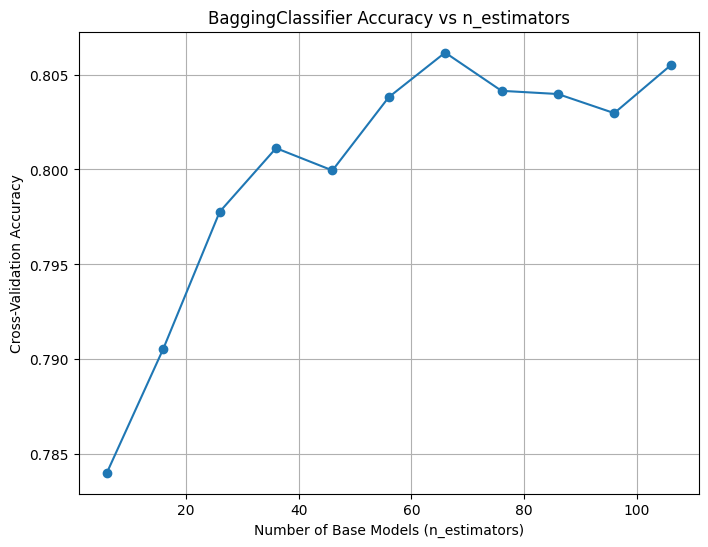

In [12]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

n_estimators_list = np.arange(6, 116, 10)
cv_scores = []


for n in n_estimators_list:
    model = BaggingClassifier(
        estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=1),
        n_estimators=n,
        random_state=42
    )
    # Кросс-валидация
    scores = cross_val_score(model, features, label, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(n_estimators_list, cv_scores, marker='o')
plt.xlabel("Number of Base Models (n_estimators)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("BaggingClassifier Accuracy vs n_estimators")
plt.grid(True)
plt.show()

4.2: Из графика видно, что наилучший показатель кросс-валидации находится при n_estimators = 66 и равен примерно 0,806. Она отличается от наилучшей accuracy и в числе базовых моделей и в значении, это связано с тем, что кросс-валидация усредняет результаты по 5 фолдам, что делает точность более стабильной, но ниже из-за оценки на разных выборках. Само значение кросс-валидации досаточно близко к 1, следовательно модель корректно обучена. Наилучшее значение accuracy для BaggingClassifier равно 0.834, что также является хорошим показателем. По classification report можно сказать, что модель практически во всех случаях корректно выделяет класс 1 в силу того, что в нем намного больше элементов, чем в классе 0.